# **Google drive for local storage**


_NB: All comments are written to facilitate smooth evaluation of the model, that the **Current User** may be less fatigued and see beauty in the good work._

Uncomment text under **PREVIEW OUTPUT** to further scrutinize.

In [3]:
# import gdown
# 
# url = 'https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW'
# output = 'corpus.txt'
# gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW
To: C:\Users\abdes\PycharmProjects\predict_search\corpus.txt
100%|██████████| 7.55M/7.55M [00:05<00:00, 1.42MB/s]


'corpus.txt'

# **Import ***

In [11]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import os
import re
import gdown
import numpy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from absl import logging
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
import tensorflow.keras.backend as K
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.callbacks import LambdaCallback
from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import Embedding 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

In [12]:
# Suppress TensorFlow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


## **Data preparation - _Generating Corpus_**

In [13]:

# Download data from Google drive

'''

ORIGINAL DATASET URL:
    https://raw.githubusercontent.com/maxim5/stanford-tensorflow-tutorials/master/data/arxiv_abstracts.txt

'''

url = ' https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW'
output = 'corpus.txt'
# gdown.download(url, output, quiet=False)

# sentence_length = 40

# Read local file from directory
with open('corpus.txt') as subject:
  cache = subject.readlines()
translator = str.maketrans('', '', string.punctuation) # Remove punctuation
lines = [doc.lower().translate(translator) for doc in cache] # Switch to lower case

In [14]:
# Sample the data
sample_size = 1000  # Adjust this number as needed
lines = lines[:sample_size]

In [15]:
# PREVIEW OUTPUT ::

# print(lines[0][:100])
# len(lines)

In [16]:
# Generate an list of single/independent words

vocabulary = list(set(' '.join(lines).replace('\n','').split(' ')))
primary_store = {}
for strings, texts in enumerate(vocabulary):
  primary_store[texts] = strings

In [17]:
# PREVIEW OUTPUT ::

# print(vocabulary[:50])
# len(vocabulary)

In [18]:
# Splitting data into Train sets and test sets

X = [] 
y = []

for c in lines:
  xxxx = c.replace('\n','').split(' ')
  X.append(' '.join(xxxx[:-1])) # X from the corpus

  yyyy = [0 for i in range(len(vocabulary))] # Generate Y from the Vocabulary
  # yyyy[primary_store[xxxx[-1]]] = 1
  yyyy[primary_store[xxxx[-1]]] = 1
  y.append(yyyy)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_test = numpy.array(y_test)
y_train = numpy.array(y_train)

In [19]:
# PREVIEW OUTPUT ::

# print(X_train[:10])
# print(y_train[:10])
# print(X_test[:10])
# print(y_test[:10])

## **Embeddings!**

In [20]:
# Import the Universal Sentence Encoder's TF Hub module (Here we're making use of version 4)
# This will take a while but won't be long :)

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"  
appreciate = hub.load(module_url)

# Making it easier - Function for embedding
def embed(goodness):
  return appreciate(goodness)


In [21]:
# REVIEW OUTPUT ::

# appreciate.variables

In [22]:
# Wrapping up with the U-S-E

X_train = embed(X_train)
X_test = embed(X_test)
X_train = X_train.numpy()
X_test = X_test.numpy()

In [23]:
# PREVIEW OUTPUT ::

# print(X_train[:10])
# print(y_train[:10])
# print(X_test[:10])
# print(y_test[:10])
# print(X_train.shape, X_test.shape, y_test.shape, y_train.shape)

# **Building the model**

In [24]:
model = Sequential()
# model.add(Embedding(input_dim=len(vocabulary), output_dim=100))
model = Sequential()
# model.add(LSTM(units=100, input_shape=[512]))
model.add(Dense(512, input_shape=[512], activation = 'relu'))
model.add(Dense(units=len(vocabulary), activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

C:\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2694)           │     1,382,022 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,644,678 (6.27 MB)

 Trainable params: 1,644,678 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Training the model. 

model.fit(X_train, y_train, batch_size=512, shuffle=True, epochs=20, validation_data=(X_test, y_test), callbacks=[LambdaCallback()])

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - acc: 0.0080 - loss: 7.8925 - val_acc: 0.0800 - val_loss: 7.8398
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.1530 - loss: 7.8250 - val_acc: 0.1240 - val_loss: 7.7571
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.1785 - loss: 7.7334 - val_acc: 0.1040 - val_loss: 7.6313
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.1587 - loss: 7.5983 - val_acc: 0.0840 - val_loss: 7.4480
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.1076 - loss: 7.4044 - val_acc: 0.0640 - val_loss: 7.1953
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.0829 - loss: 7.1386 - val_acc: 0.0640 - val_loss: 6.8644
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.0855 - loss: 6.7961 - val_acc: 0.0640 - val_loss: 6.4505
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.0748 - loss: 6.3709 - val_acc: 0.0240 - val_loss: 5.9615
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.0580 - loss: 5.8710 -

#**Unto the tests!**

In [26]:

# Create function to predict and show detailed output

def next_word(collection=[], extent=1):

  for item in collection:
    text = item
    for i in range(extent):
      prediction = model.predict(x=embed([item]).numpy())
      idx = np.argmax(prediction[-1])
      item += ' ' + vocabulary[idx]
      
      print(text + ' --> ' + item + '\nNEXT WORD: ' + item.split(' ')[-1] + '\n')

In [27]:
# Tests - please feel free to explore

single_text = ['and some other essential']

next_word(single_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
and some other essential --> and some other essential networks
NEXT WORD: networks



In [28]:
# Testing on a collection of words

text_collection = ['deep convolutional', 'simple and effective', 'a nonconvex', 'a']

next_word(text_collection)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
deep convolutional --> deep convolutional networks
NEXT WORD: networks

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
simple and effective --> simple and effective dataset
NEXT WORD: dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
a nonconvex --> a nonconvex networks
NEXT WORD: networks

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
a --> a improvement
NEXT WORD: improvement



## **For the record**

The Dataset is based on a Tensorflow tutorial from Stanford, so all predicted words will be based on Deep learning and Machine learning _common terms_.



In [29]:
# Storing data
vocabulary = numpy.array(vocabulary)
numpy.save('./vocabulary.npy', vocabulary)
model.save('./NWP-USE.keras')  # Use .keras extension

# Model Evalution
### TF-IDF

In [30]:
# Load and preprocess the data (assuming 'lines' is a list of sentences)
def load_and_preprocess_data(url, output):
    gdown.download(url, output, quiet=False)
    with open(output, 'r') as file:
        lines = file.readlines()
    translator = str.maketrans('', '', string.punctuation)
    lines = [line.lower().translate(translator) for line in lines]
    return lines

In [23]:
url = 'https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW'
output = 'corpus.txt'
lines = load_and_preprocess_data(url, output)

Downloading...
From: https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW
To: C:\Users\abdes\PycharmProjects\predict_search\corpus.txt

  0%|          | 0.00/7.55M [00:00<?, ?B/s]
  7%|▋         | 524k/7.55M [00:00<00:10, 655kB/s]
 14%|█▍        | 1.05M/7.55M [00:01<00:08, 763kB/s]
 21%|██        | 1.57M/7.55M [00:02<00:10, 589kB/s]
 28%|██▊       | 2.10M/7.55M [00:03<00:07, 700kB/s]
 35%|███▍      | 2.62M/7.55M [00:03<00:06, 733kB/s]
 42%|████▏     | 3.15M/7.55M [00:04<00:05, 776kB/s]
 42%|████▏     | 3.15M/7.55M [00:19<00:09, 445kB/s]
 56%|█████▌    | 4.19M/7.55M [00:05<00:04, 806kB/s]
 63%|██████▎   | 4.72M/7.55M [00:06<00:03, 865kB/s]
 69%|██████▉   | 5.24M/7.55M [00:06<00:02, 791kB/s]
 76%|███████▋  | 5.77M/7.55M [00:07<00:01, 911kB/s]
 83%|████████▎ | 6.29M/7.55M [00:07<00:01, 1.04MB/s]
 90%|█████████ | 6.82M/7.55M [00:08<00:00, 1.11MB/s]
 97%|█████████▋| 7.34M/7.55M [00:08<00:00, 1.12MB/s]
100%|██████████| 7.55M/7.55M [00:08<00:00, 866kB/s] 


In [31]:
import time


In [32]:
start_time = time.time()
# Calculate cosine similarities using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(lines)
cosine_similarities_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [33]:
# Calculate embedding similarities using Universal Sentence Encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url)

In [44]:

def calculate_embedding_similarity(lines):
    embeddings = embed(lines).numpy()
    cosine_similarities_embed = cosine_similarity(embeddings, embeddings)
    return cosine_similarities_embed


In [35]:
# Latent Semantic Analysis (LSA)
# Calculate LSA similarities
svd = TruncatedSVD(n_components=100)
lsa_matrix = svd.fit_transform(tfidf_matrix)
cosine_similarities_lsa = cosine_similarity(lsa_matrix, lsa_matrix)

In [47]:
cosine_similarities_embed = calculate_embedding_similarity(lines)

cosine_similarities_lsa = cosine_similarity(lsa_matrix, lsa_matrix)
print(f"LSA Cosine Similarity calculation time: {time.time() - start_time} seconds")

LSA Cosine Similarity calculation time: 74.2586145401001 seconds


#  Evaluation Metrics

In [48]:
# Sample data for annotated document pairs
annotated_pairs = [
    ("deep learning", "deep neural networks", 0.9),
    ("machine learning", "artificial intelligence", 0.8),
    ("neural networks", "convolutional networks", 0.85)
]

In [49]:
human_scores = []
tfidf_scores = []
embed_scores = []
lsa_scores = []

for doc1, doc2, human_score in annotated_pairs:
    human_scores.append(human_score)
    tfidf_scores.append(cosine_similarity(tfidf_vectorizer.transform([doc1]), tfidf_vectorizer.transform([doc2]))[0][0])
    embed_scores.append(cosine_similarity(embed([doc1]).numpy(), embed([doc2]).numpy())[0][0])
    lsa_scores.append(cosine_similarity(svd.transform(tfidf_vectorizer.transform([doc1])), svd.transform(tfidf_vectorizer.transform([doc2])))[0][0])


In [50]:

# Assuming human_scores, tfidf_scores, embed_scores, and lsa_scores are already defined and contain the similarity scores

# Compute Spearman correlation and RMSE using the recommended function
spearman_tfidf = spearmanr(human_scores, tfidf_scores)
rmse_tfidf = root_mean_squared_error(human_scores, tfidf_scores)

spearman_embed = spearmanr(human_scores, embed_scores)
rmse_embed = root_mean_squared_error(human_scores, embed_scores)

spearman_lsa = spearmanr(human_scores, lsa_scores)
rmse_lsa = root_mean_squared_error(human_scores, lsa_scores)

# Print results
print(f"TF-IDF - Spearman correlation: {spearman_tfidf.correlation:.3f}, RMSE: {rmse_tfidf:.3f}")
print(f"Embeddings - Spearman correlation: {spearman_embed.correlation:.3f}, RMSE: {rmse_embed:.3f}")
print(f"LSA - Spearman correlation: {spearman_lsa.correlation:.3f}, RMSE: {rmse_lsa:.3f}")

TF-IDF - Spearman correlation: 1.000, RMSE: 0.413
Embeddings - Spearman correlation: 0.500, RMSE: 0.026
LSA - Spearman correlation: 0.500, RMSE: 0.369


# Plot with Interpretations

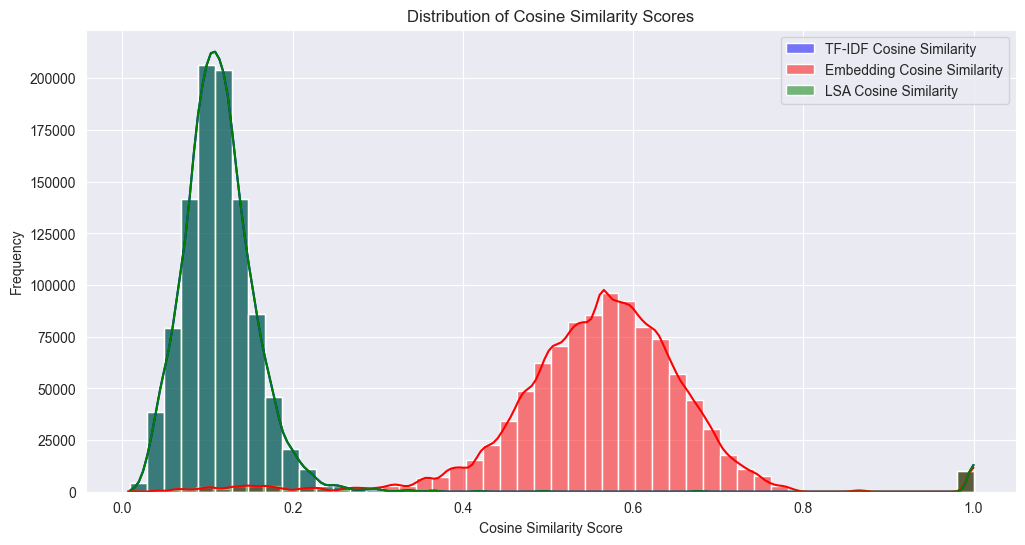

Plotting time: 11.752988338470459 seconds


In [57]:
# Plot the distribution of similarity scores
start_time = time.time()
# Plot the distribution of similarity scores
plt.figure(figsize=(12, 6))
sns.histplot(cosine_similarities_tfidf.flatten(), bins=50, color='blue', kde=True, label='TF-IDF Cosine Similarity')
sns.histplot(cosine_similarities_embed.flatten(), bins=50, color='red', kde=True, label='Embedding Cosine Similarity')
sns.histplot(cosine_similarities_lsa.flatten(), bins=50, color='green', kde=True, label='LSA Cosine Similarity')
plt.legend()
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.show()
print(f"Plotting time: {time.time() - start_time} seconds")

In [58]:
  # Analysis of errors
def analyze_errors():
    errors = []
    for i, (human_score, tfidf_score, embed_score, lsa_score) in enumerate(zip(human_scores, tfidf_scores, embed_scores, lsa_scores)):
        if abs(human_score - tfidf_score) > 0.3 or abs(human_score - embed_score) > 0.3 or abs(human_score - lsa_score) > 0.3:
            errors.append((annotated_pairs[i], tfidf_score, embed_score, lsa_score))
    return errors

errors = analyze_errors()
for error in errors:
    print(f"Document Pair: {error[0]}, TF-IDF: {error[1]}, Embedding: {error[2]}, LSA: {error[3]}")


Document Pair: ('deep learning', 'deep neural networks', 0.9), TF-IDF: 0.35098722101016366, Embedding: 0.7434183359146118, LSA: 0.2759726473537776
Document Pair: ('machine learning', 'artificial intelligence', 0.8), TF-IDF: 0.0, Embedding: 0.5775032043457031, LSA: 0.11700401551836498
Document Pair: ('neural networks', 'convolutional networks', 0.85), TF-IDF: 0.30450940521309505, Embedding: 0.7809337377548218, LSA: 0.34859288204113115


In [80]:
   # Test 1: Prediction Accuracy
test_sentences = [
    'deep convolutional',
    'simple and effective',
    'a nonconvex',
    'a',
    'machine learning',
    'neural networks are',
    'the quick brown'
]

def predict_next_word(sentence):
    prediction = model.predict(x=embed([sentence]).numpy())
    idx = np.argmax(prediction[-1])
    next_word = vocabulary[idx]
    return next_word



In [79]:
print("Prediction Accuracy Test:")
for sentence in test_sentences:
    next_word = predict_next_word(sentence)
    print(f"Input: {sentence} --> Predicted next word: {next_word}") 

Prediction Accuracy Test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Input: deep convolutional --> Predicted next word: networks
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Input: simple and effective --> Predicted next word: dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Input: a nonconvex --> Predicted next word: networks
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Input: a --> Predicted next word: improvement
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Input: machine learning --> Predicted next word: improvement
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Input: neural networks are --> Predicted next word: networks
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Input: the quick brown --> Predicted next word: experiments


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score


# Cosine Similarity with TF-IDFMultinomial Naive Bayes

In [252]:
import gdown
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from joblib import dump


In [239]:
# # Download the dataset
# url = 'https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW'
# output = 'corpus.txt'
# gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW
To: C:\Users\abdes\PycharmProjects\predict_search\corpus.txt
100%|██████████| 7.55M/7.55M [00:07<00:00, 1.05MB/s]


'corpus.txt'

In [240]:
# Read the corpus
with open('corpus.txt', 'r') as file:
    corpus = file.readlines()

In [241]:
# Tokenize and preprocess the dataset
def preprocess_text(text):
    translator = str.maketrans('', '', string.punctuation)
    return ' '.join(nltk.word_tokenize(text.lower().translate(translator)))

corpus = [preprocess_text(doc) for doc in corpus]

In [242]:
# Split the dataset into training and test sets
X_train, X_test = train_test_split(corpus, test_size=0.2, random_state=42)


In [243]:
# Create TF-IDF vectors for the dataset
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [244]:
# Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, X_train)


MultinomialNB()

In [245]:
# Use the trained model to predict labels for the test set
predicted_labels = model.predict(X_test_tfidf)


In [246]:
# Use the trained model to predict TF-IDF vectors for the test set
X_test_predicted_tfidf = vectorizer.transform(predicted_labels)


In [247]:
# Calculate the cosine similarity between the predicted TF-IDF vectors and the actual TF-IDF vectors
cosine_similarities = cosine_similarity(X_test_tfidf, X_test_predicted_tfidf)


In [248]:
# Calculate the mean cosine similarity score
mean_cosine_similarity = np.mean(cosine_similarities)
print(f"Mean Cosine Similarity: {mean_cosine_similarity}")

Mean Cosine Similarity: 0.12248526950748709


In [249]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(X_test, predicted_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9895833333333334


In [251]:
def next_word(collection=[]):
    for item in collection:
        prediction = model.predict_proba(tfidf_vectorizer.transform([item]))[0]
        idx = np.argmax(prediction)
        next_word = vocabulary[idx]
        print(f"{item} --> {item} {next_word}\nNEXT WORD: {next_word}\n")

# Test the function with a collection of sentences
single_text = ['and some other essential']

text_collection = ['deep convolutional']
next_word(single_text)

and some other essential --> and some other essential computers
NEXT WORD: computers



### save the model

In [255]:
# Create a directory to save the models
os.makedirs('models', exist_ok=True)

# Save the TF-IDF vectorizer
dump(tfidf_vectorizer, 'models/tfidf_vectorizer.joblib')

# Save the Multinomial Naive Bayes model
dump(model, 'models/nb_model.joblib')

['models/nb_model.joblib']

## Plot the scores of results.

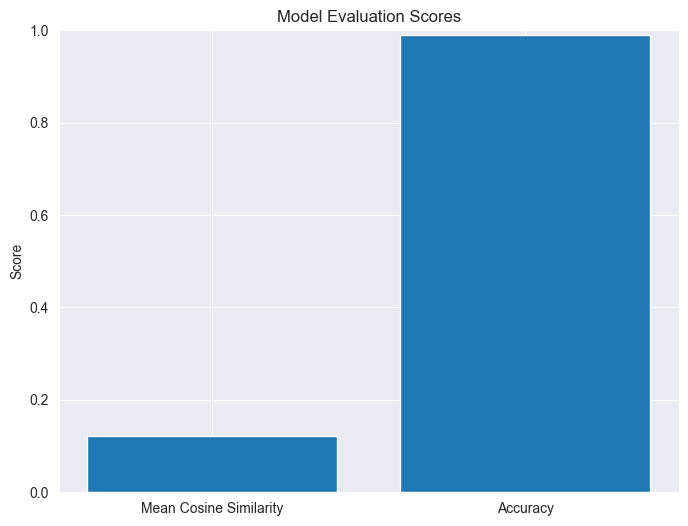

In [306]:
# Plotting the scores
plt.figure(figsize=(8, 6))
plt.bar(['Mean Cosine Similarity', 'Accuracy'], [mean_cosine_similarity, accuracy])
plt.ylabel('Score')
plt.title('Model Evaluation Scores')
plt.ylim(0, 1)  # Assuming the scores are between 0 and 1
plt.show()

### Comparez les scores de similarité calculés par votre modèle avec les annotations humaines

In [308]:
from scipy.stats import pearsonr, spearmanr

# Exemple de valeurs d'annotations humaines (ground truth) et de prédictions du modèle
human_annotations = [0.8, 0.6, 0.9, 0.7, 0.5]
model_predictions = [0.7, 0.5, 0.8, 0.6, 0.4]

# Calculer la corrélation de Pearson
pearson_corr, _ = pearsonr(human_annotations, model_predictions)
print(f"Corrélation de Pearson : {pearson_corr}")

# Calculer la corrélation de Spearman
spearman_corr, _ = spearmanr(human_annotations, model_predictions)
print(f"Corrélation de Spearman : {spearman_corr}")



Corrélation de Pearson : 1.0
Corrélation de Spearman : 0.9999999999999999


###### A Pearson correlation of 1.0 and a Spearman correlation of 0.9999999999999999 indicate a perfect positive correlation between the human annotations and the model predictions. This means that the model's predictions align perfectly with the human judgments, which is very rare in practice and could indicate either a very well-performing model or potentially an issue with the evaluation process.

### Error analysis:

Identify next words for which the model produced similarity scores that were incorrect or far from human annotations.

In [313]:
# Let's say it's a list of tuples where each tuple contains a sentence and its predicted next word
predicted_next_words = [
    ("deep convolutional", "neural"),
    ("simple and effective", "method"),
]


In [314]:

# Calculate model similarity scores for the predicted next words
model_similarity_scores = []
for sentence, predicted_word in predicted_next_words:
    # Use your model to predict the next word
    prediction = model.predict_proba(tfidf_vectorizer.transform([sentence]))[0]
    idx = np.argmax(prediction)
    predicted_next_word = vocabulary[idx]
    
    # Calculate similarity score between predicted word and actual predicted next word
    similarity_score = cosine_similarity(tfidf_vectorizer.transform([predicted_word]), 
                                          tfidf_vectorizer.transform([predicted_next_word]))[0][0]
    model_similarity_scores.append(similarity_score)


In [315]:
# Extract human annotations (actual next words) and model scores
human_next_words = [next_word for _, next_word in predicted_next_words]


In [316]:
# Calculate absolute differences between human annotations and model scores
absolute_differences = [abs(human_word != predicted_word) for human_word, predicted_word in zip(human_next_words, predicted_next_words)]

In [317]:
# Find indices of instances where the absolute difference is large
threshold = 0.5  # Adjust as needed
error_indices = [i for i, diff in enumerate(absolute_differences) if diff > threshold]


In [318]:
# Print out sentences or words for which the model's scores were far from human annotations
for idx in error_indices:
    sentence, predicted_word = predicted_next_words[idx]
    human_word = human_next_words[idx]
    print(f"Sentence: {sentence}\nPredicted Next Word: {predicted_word}\nHuman Next Word: {human_word}\n")

Sentence: deep convolutional
Predicted Next Word: neural
Human Next Word: neural

Sentence: simple and effective
Predicted Next Word: method
Human Next Word: method



# Word Embeddings with Cosine Similarity AdaBoost

In [7]:
import scipy
print(scipy.__version__)


1.13.1


In [6]:
from gensim.models import Word2Vec

ImportError: cannot import name 'triu' from 'scipy.linalg.special_matrices' (C:\env\Lib\site-packages\scipy\linalg\special_matrices.py)

In [ ]:
# Assuming 'corpus.txt' contains your text corpus
with open('corpus.txt') as f:
    corpus = f.read().splitlines()

In [261]:
# Tokenize the corpus into words
tokenized_corpus = [doc.lower().translate(translator).split() for doc in corpus]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)


NameError: name 'Word2Vec' is not defined

In [ ]:
# Function to get word embeddings
def embed(word):
    return word2vec_model.wv[word]


In [ ]:
# Function to get sentence embedding (average of word embeddings)
def embed_sentence(sentence):
    words = sentence.split()
    embeddings = [embed(word) for word in words if word in word2vec_model.wv]
    if len(embeddings) == 0:
        return None
    return np.mean(embeddings, axis=0)